<div align='left'>
<a href='http://www.ic.uff.br'>
<img align='left' src='http://www.proac.uff.br/logotipos/sites/default/files/images/logo-instituto-de-computacao.preview.png' alt='IC logo' title='IC logo' width='20%'/>
</a>
</div>

# Understanding the Perceptron

## [Luis Martí](http://lmarti.com) - [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)

In this notebook we are doing to study the [perceptron](https://en.wikipedia.org/wiki/Perceptron) and its learning algorithm.

The perceptron is an algorithm for learning a binary classifier. That is a function that maps its input $\newcommand{\vec}[1]{\mathbf{#1}}\vec{x}\in\mathbb{R}^n$ (a real-valued vector) to an output value $f(\vec{x})$ (a single binary value) as,

$$
f(\vec{x}) = \begin{cases}
                1 & \text{if }\vec{w} \cdot \vec{x} + b > 0\,,\\
                0 & \text{otherwise};
             \end{cases}
$$

where $\vec{w}$ is a vector of real-valued *weights*, $\vec{w} \cdot \vec{x}$ is the *dot product* $\sum_{i=1}^n w_i x_i$, and $b$ is known as the *bias*. 

## Preparing the environment 

The environment used for the notebook is the following:

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,pandas

CPython 3.4.3
IPython 4.0.0

numpy 1.9.3
pandas 0.16.2

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random, itertools
random.seed(a=42)

*Note*: I am fixing a given random seed to always have a the same result. You should not do this in practice (nor in the exercises of the class). 

## Implementing the Perceptron

We are going to start implementing a perceptron as a class. 

*Note*: Bear in mind that I have made the implementation as clear and easy to follow as possible and, therefore, I have sacrificed performance in the sake of clarity. There are many points where it can be improved.

In [3]:
class Perceptron:
    'A simple Perceptron implementation.'
    def __init__(self, weights, bias, alpha=0.1):
        self.weights = weights
        self.bias = bias
        self.alpha = alpha
    
    def propagate(self, x):
        return self.activation(self.net(x)) 
        
    def activation(self, net):
        if net > 0:
            return 1
        return 0
    
    def net(self, x):
        return np.dot(self.weights, x) + self.bias
    
    def learn(self, x, y):
        y_hat = self.propagate(x)
        self.weights = [ w_i + self.alpha*x_i*(y-y_hat) for (w_i, x_i) in zip(self.weights, x)]
        self.bias = self.bias + self.alpha*(y-y_hat)
        return np.abs(y_hat - y)

Perhaps the most tricky element of our `Perceptron` class is the `learn` method. 

It goes by calculating the prediction of the perceptron, $\hat{y}$, as

$$\hat{y} = f[\mathbf{w}\cdot\mathbf{x} + b] = f[ w_{1}x_{1} + w_2x_{2} + \cdots + w_nx_{n}+b]\,.$$

After that, we update the weights and the bias using the perceptron rule:

$$
\begin{align}
w_i & = w_i + \alpha (y - \hat{y}) x_{i} \,,\  i=1,\ldots,n\,;\\
b & = b + \alpha (y - \hat{y})\,.
\end{align}
$$

Here $\alpha\in\left(0,1\right]$ is known as the *learning rate*.

## Preparing the data set

After having the perceptron implementation ready we need an example data set.

We are going to create a dataset containing random points such that $\mathbf{x}\in\left[0,1\right]^2$.

In [4]:
size = 50 # size of data set

In [5]:
data = pd.DataFrame(columns=('$x_1$', '$x_2$'),
                    data=np.random.uniform(size=(size,2)))

So far, our data set looks like this (we are showning only the first ten elements):

In [6]:
data.head(10)

,$x_1$,$x_2$
0,0.176998,0.845451
1,0.357229,0.497691
2,0.643802,0.285172
3,0.977791,0.888909
4,0.053478,0.361519
5,0.268272,0.116245
6,0.420868,0.167383
7,0.701919,0.084028
8,0.592559,0.555809
9,0.154669,0.385328


We need to add a *target* or *classification* attribute. In this example, we are going to make this target to be equal to one if the point lies in the upper-right triangle of the $\left[0,1\right]\times\left[0,1\right]$ square and zero otherwise:

<div align='center'>
<img src='figs/dataset.jpeg' alt='description of the data set' title='description of the data set' width='38%'/>
</div>

We can formalize this condition as:

$$
y = \begin{cases}
    1 & \ \text{if}\ x_1 + x_2 > 1\,,\\
    0 & \ \text{otherwise}\,.
    \end{cases}
$$

Lets code it...

In [7]:
def condition(x):
    return int(np.sum(x) > 1)

...and apply this condition to the data set.

In [8]:
data['y'] = data.apply(condition, axis=1)

The resulting data set looks like this:

In [9]:
data.head(10)

,$x_1$,$x_2$,y
0,0.176998,0.845451,1
1,0.357229,0.497691,0
2,0.643802,0.285172,0
3,0.977791,0.888909,1
4,0.053478,0.361519,0
5,0.268272,0.116245,0
6,0.420868,0.167383,0
7,0.701919,0.084028,0
8,0.592559,0.555809,1
9,0.154669,0.385328,0


We can now take a better look at the data set in graphical form. Elements with $y=1$ are shown in red ($\color{red}{\bullet}$) and those with $y=0$ are shown in gray ($\color{gray}{\bullet}$):

In [10]:
def plot_data(data, ax):
    data[data.y==1].plot(kind='scatter', 
                         x='$x_1$', y='$x_2$', 
                         color='Red', ax=ax)
    data[data.y==0].plot(kind='scatter', 
                         x='$x_1$', y='$x_2$', 
                         color='Gray', ax=ax)
    ax.set_xlim(-0.1,1.1); ax.set_ylim(-0.1,1.1)

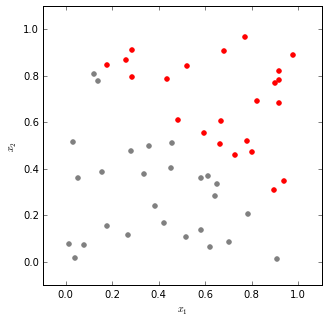

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
plot_data(data, ax)

## Iterating the data set

Having the data set we can now code how the perceptron learns it by iterating throu it.

In [12]:
def learn_data(perceptron, data):
    'Returns the number of errors made.'
    count = 0 
    for i, row in data.iterrows():
        count += perceptron.learn(row[0:2], row[2])
    return count

## Visualizing learning

We need now to plot the decision boundary or threshold of the perceptron.

To calculate it we start with the equation that describes the boundary,
$$w_1x_1+w_2x_2 + b =0.$$

From it we can obtain $x_2$ from a given $x_1$ applying a fairy simple math,
$$x_2 = \frac{-w_1x_1-b}{w_2}.$$

In [13]:
def threshold(perceptron, x_1):
    return (-perceptron.weights[0] * x_1 - perceptron.bias) / perceptron.weights[1]

In [14]:
def plot_perceptron_threshold(perceptron, ax):
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    
    x2s = [threshold(perceptron, x1) for x1 in xlim]
    ax.plot(xlim, x2s)
    
    ax.set_xlim(-0.1,1.1); ax.set_ylim(-0.1,1.1)

A function that plots a perceptron as the threshold and the data set.

In [15]:
def plot_all(perceptron, data, t, ax=None):
    if ax==None:
        fig = plt.figure(figsize=(5,4))
        ax = fig.gca()
    plot_data(data, ax)
    plot_perceptron_threshold(perceptron, ax)
    
    ax.set_title('$t='+str(t+1)+'$')

## Our perceptron in action

All set now! Let's create a perceptron and train it. 

*Note*: Normally the initial weights and the bias should be set to *small* random values. I am setting them by hand to a value that I know that looks good in the examples.

In [16]:
perceptron = Perceptron([0.1,-0.1],0.02)

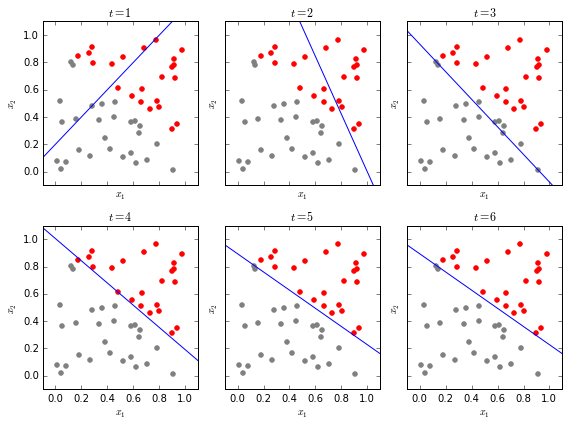

In [17]:
f, axarr = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8,6))
axs = list(itertools.chain.from_iterable(axarr))
for t in range(6):
    plot_all(perceptron, data, t, ax=axs[t])
    learn_data(perceptron, data)
f.tight_layout()

It is clear how the Perceptron threshold is progresively adjusted according to the data set.

## Animating the Perceptron

This results are better understood in animated from.

In [18]:
from JSAnimation import IPython_display
from matplotlib import animation

In [19]:
def animate(frame_index, perceptron, data, ax):
    ax.clear()
    plot_data(data, ax=ax)
    ax.set_title('$t='+str(frame_index)+'$')
    
    if not frame_index:
        return None
    plot_perceptron_threshold(perceptron, ax=ax)
    learn_data(perceptron, data)
    return None


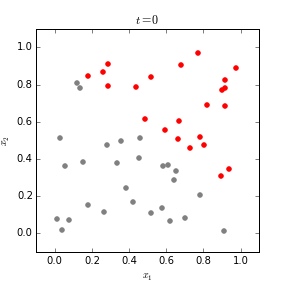
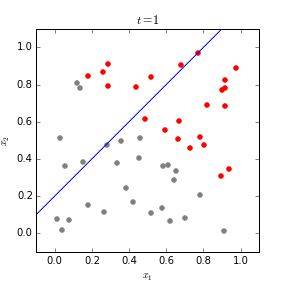
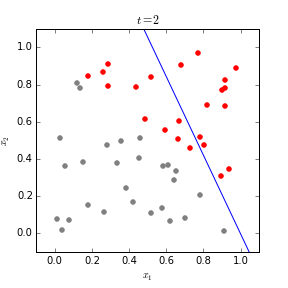
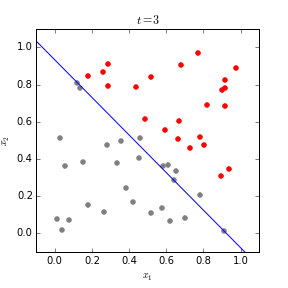
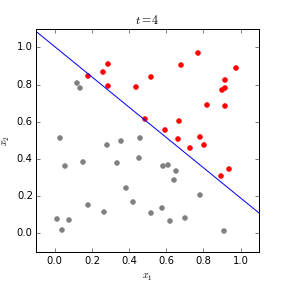
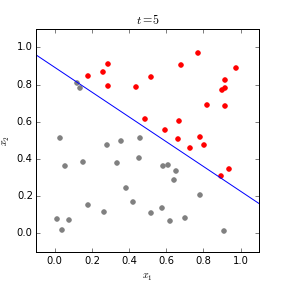
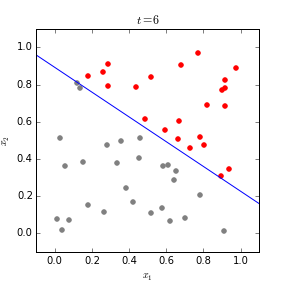
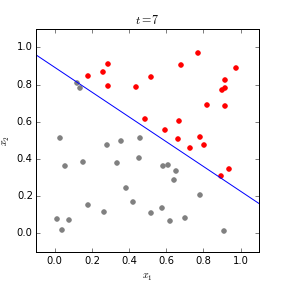
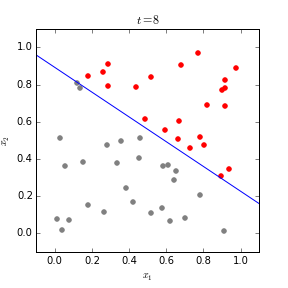
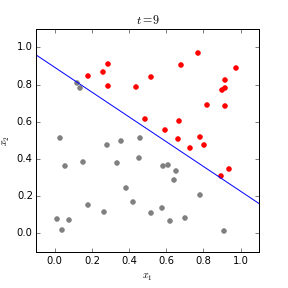

In [20]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
perceptron = Perceptron([0.1,-0.1],0.02)
animation.FuncAnimation(fig, lambda i: animate(i, perceptron, data, ax), frames=10, interval=600, 
                               blit=True)

## Self-study

* Experiment with the learning rate ($\alpha$). How it impacts learning?
* Create a new data set with a non-linear boundary. What happens now with our perceptron? How would you fix it?

## Suggested reading

* Minsky M. L. and Papert S. A. (1969). *Perceptrons*. Cambridge, MA: MIT Press.
* Gallant, S. I. (1990). *Perceptron-based learning algorithms*. IEEE Transactions on Neural Networks, vol. 1, no. 2, pp. 179–191.
* Mikel Olazaran (1996). *A Sociological Study of the Official History of the Perceptrons Controversy*. Social Studies of Science 26 (3): 611–659. doi:10.1177/030631296026003005.